<a href="https://colab.research.google.com/github/rgranit/academix-ydata-project/blob/master/code/1_merged_datasets_for_labeled_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Outline

Merges the NIH dataset and the Academix dataset and removes duplicates.

**Data Available**

> Enriched Dataset: 96K <br>
> Not Enriched Dataset: 20K 

**Instances of Author Disambiguation**

Details at the bottom

## Initializations

In [5]:
from boto.s3.connection import S3Connection
from boto.s3.key import Key
from boto import s3
import boto3, os, re
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

PATH = "data/labeled_dataset/"
FILE = "NIH_postcleaning_large.csv"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
import importlib
importlib.reload(utils)

<module 'utils' from '/content/AYP/code/utils.py'>

In [7]:
if os.path.exists(PATH + FILE):
  print("Getting NIH from File")
  df_nih = pd.read_csv(file= PATH + File)
  df_nih.drop('Unnamed: 0',axis=1, inplace=True)

else:
  print("Getting NIH from S3")
  df_nih = utils.get_dataframe_from_s3(file=FILE)    
  df_nih.drop('Unnamed: 0',axis=1, inplace=True)

# Retrieve Enriched Academix Data
print("Getting Academix Enriched Dataset from S3")
df_aca_r = utils.get_dataframe_from_s3(file="academix_enriched_large.json",type="json")
#df_aca_r.drop('Unnamed: 0',axis=1, inplace=True)

# Retrieve Not Enriched Academix Data
print("Getting Academic non-enriched Dataset from S3")
df_aca_nr = utils.get_dataframe_from_s3(file="academix_not_enriched.csv")
df_aca_nr.drop('Unnamed: 0',axis=1, inplace=True)

Getting NIH from S3
Getting Academix Enriched Dataset from S3
Getting Academic non-enriched Dataset from S3


## Implementation

In [8]:
df_nih.head()

,PMID,ORG_STATE,PI_IDS,cleaned_name
0,30147749,PA,8352708,"Madabhushi, A"
1,30147749,PA,9354221,"Paladini, G"
2,30147749,PA,9258689,"Wang, F"
3,19810465,PA,8352708,"Madabhushi, A"
4,19810465,PA,9354221,"Paladini, G"


In [9]:
df_aca_r.head()

,authors,doi,journal_name,language,last_author,last_author_country,last_author_email,last_author_id,last_author_inst,last_author_name,mesh,mesh_major,pmid,pub_year,title
0,"[{'forename': 'Iris', 'affiliation': '*Departm...",None,Journal of acquired immune deficiency syndrome...,eng,None,United States,None,2451839.0,None,"Eshleman, SH","[Adult, Genotype, Humans, Male]","[African Americans, Anti-HIV Agents/therapeuti...",25861015,2015.0,Antiretroviral Drug Use and HIV Drug Resistanc...
1,"[{'forename': 'Andrew D', 'affiliation': 'Divi...",10.1136/sextrans-2014-051867,Sexually transmitted infections,eng,{'affiliation': 'Division of Intramural Resear...,United States,None,2055060.0,None,"Reynolds, SJ","[Adult, C-Reactive Protein/analysis, Disease P...","[Acyclovir/therapeutic use, Antiviral Agents/t...",25904747,2015.0,Decreased monocyte activation with daily acycl...
2,"[{'forename': 'Molly', 'affiliation': 'From th...",None,Sexually transmitted diseases,eng,None,Ghana,None,2379925.0,None,"Kahn, K","[Adolescent, Commerce, Cross-Sectional Studies...","[Alcohol Drinking/adverse effects, Condoms/sta...",25868138,2015.0,Relationship between community-level alcohol o...
3,"[{'forename': 'Ruchi M', 'affiliation': 'Broad...",None,Journal of virology,eng,{'affiliation': 'Department of Microbiology an...,United States,None,1634716.0,Harvard Medical School,"Knipe, DM","[Geography, Herpesvirus 2, Human/classificatio...","[Genetic Variation, Genome, Viral]",26018166,2015.0,Genome Sequencing and Analysis of Geographical...
4,"[{'forename': 'Susanna L', 'affiliation': 'Bio...",None,Journal of virology,eng,{'affiliation': 'Laboratory of Immunoregulatio...,United States,None,1696360.0,Mount Auburn Hospital,"Quinn, TC","[Animals, Humans, Phylogeny]","[Glycoproteins/metabolism, Herpesvirus 1, Huma...",26018161,2015.0,Global Diversity within and between Human Herp...


In [0]:
#Make sure both df's have the same column names
df_nih.rename(columns={'cleaned_name':'last_author_name',
                          'PMID':'pmid'}, 
                 inplace=True)

In [0]:
df_join = pd.merge(left=df_nih, right=df_aca_r, how="inner",on=['last_author_name','pmid'],suffixes=('_nih','_aca_r'))

In [12]:
df_aca_r[df_aca_r.pmid == 29956882]

,authors,doi,journal_name,language,last_author,last_author_country,last_author_email,last_author_id,last_author_inst,last_author_name,mesh,mesh_major,pmid,pub_year,title
41788,"[{'forename': 'Michelle L', 'affiliation': 'De...",10.1002/jia2.25149,Journal of the International AIDS Society,eng,"{'affiliation': 'Kirby Institute, UNSW, Sydney...",Australia,None,70221.0,None,"Law, M","[Adult, CD4 Lymphocyte Count, Cohort Studies, ...","[Anti-HIV Agents/therapeutic use, HIV Infectio...",29956882,2018.0,Sex-based differences in antiretroviral therap...


In [0]:
#check for duplicates
df_join.drop_duplicates(subset=['pmid','PI_IDS','last_author_name'],keep='first',inplace=True)

In [14]:
df_join.shape

(196609, 17)

We have 196K of datapoints here with labeles ID's for pubmed.

In [15]:
np.any(df_join.groupby(['pmid','PI_IDS']).size() > 1)

False

***Repeat for non enriched dataset.***

In [0]:
df_join_nr = pd.merge(left=df_nih, right=df_aca_nr, how="inner",on=['last_author_name','pmid'],suffixes=('_nih','_aca_nr'))

In [0]:
#check for duplicates
df_join_nr.drop_duplicates(keep="first",inplace=True)

In [18]:
df_join_nr.shape

(22384, 12)

In [19]:
np.any(df_join_nr.groupby(['pmid','PI_IDS']).size() > 1)

True

In [0]:
#Want to keep people only where they're # of PI_IDS <= # of pmid
#This will correct the dirty data pre-existing within the NIH Dataset

#Enriched dataset
author_list = df_join.groupby('last_author_name')[['PI_IDS','pmid']].nunique()
good_authors = author_list[author_list['PI_IDS'] <= author_list['pmid']].index
df_join = df_join.loc[df_join['last_author_name'].isin(good_authors)]

#Non-enriched dataset

author_list = df_join_nr.groupby('last_author_name')[['PI_IDS','pmid']].nunique()
good_authors = author_list[author_list['PI_IDS'] <= author_list['pmid']].index
df_join_nr = df_join_nr.loc[df_join_nr['last_author_name'].isin(good_authors)]

Found that in the NIH dataset, the same pmid with the same last_author_name was given two dif. PI_IDS, which is an obvious flaw so we drop those duplicates so that our data is cleaner.

In [21]:
df_test = df_join.groupby(['pmid','last_author_name'])[['PI_IDS']].nunique()
df_test_fix = df_test[df_test.PI_IDS > 1].reset_index()
for row in df_test_fix.iterrows():
  t_pmid,t_lan,_ = row[1]
  df_fix = df_join[(df_join.pmid == t_pmid) & (df_join.last_author_name == t_lan)]
  f_pid = df_fix.iloc[0].PI_IDS
  df_join.loc[(df_join.pmid == t_pmid) & (df_join.last_author_name == t_lan),'PI_IDS'] = f_pid
df_join.drop_duplicates(subset=['pmid','last_author_name'], keep='first',inplace=True)
np.any(df_join.duplicated(subset=['pmid','last_author_name']))

False

In [22]:
df_test = df_join_nr.groupby(['pmid','last_author_name'])[['PI_IDS']].nunique()
df_test_fix = df_test[df_test.PI_IDS > 1].reset_index()
for row in df_test_fix.iterrows():
  t_pmid,t_lan,_ = row[1]
  df_fix = df_join_nr[(df_join_nr.pmid == t_pmid) & (df_join_nr.last_author_name == t_lan)]
  f_pid = df_fix.iloc[0].PI_IDS
  df_join_nr.loc[(df_join_nr.pmid == t_pmid) & (df_join_nr.last_author_name == t_lan),'PI_IDS'] = f_pid
df_join_nr.drop_duplicates(subset=['pmid','last_author_name'], keep='first',inplace=True)
np.any(df_join_nr.duplicated(subset=['pmid','last_author_name']))

False

Also need to ensure that for each PI_IDS there is only one last_author_name:

In [0]:
test =df_join.groupby('PI_IDS')[['last_author_name']].nunique()
fix_PIIDS = test[test.last_author_name > 1].index
for pid in fix_PIIDS:
  longest_name = max(list(df_join[df_join.PI_IDS == pid].last_author_name.unique()),key=len)
  df_join.loc[df_join.PI_IDS == pid,'last_author_name'] = longest_name

In [0]:
test = df_join_nr.groupby('PI_IDS')[['last_author_name']].nunique()
fix_PIIDS = test[test.last_author_name > 1].index
for pid in fix_PIIDS:
  longest_name = max(list(df_join_nr[df_join_nr.PI_IDS == pid].last_author_name.unique()),key=len)
  df_join_nr.loc[df_join_nr.PI_IDS == pid,'last_author_name'] = longest_name

##Upload to S3

In [0]:
df_join.to_json('enriched_labeled_dataset_large.json', orient="records")

In [0]:
file = open("enriched_labeled_dataset_large.json", "r+")
utils.upload_to_s3(file=file,key= file.name)
file.close()

In [0]:
df_join_nr.to_csv('not_enriched_labeled_dataset_large.csv')

In [0]:
file = open("not_enriched_labeled_dataset_large.csv", "r+")
utils.upload_to_s3(file=file,key = file.name)
file.close()

## Explore Data

In [0]:
df_join_test = df_join[["pmid","PI_IDS","last_author_name"]]

In [0]:
df_join_test['PI_IDS'].nunique()

28997

In [0]:
num_da = df_join_test.groupby('last_author_name')['PI_IDS'].nunique().value_counts().sort_index()[1:]
idx = num_da.index
val = num_da

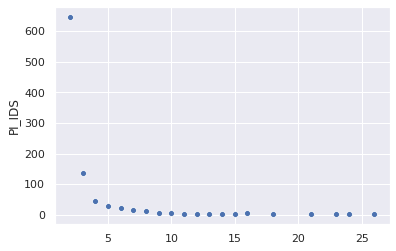

In [0]:
sns.scatterplot(idx,val,);

Number of total unique ID's: 29k<br>
Number of total unique last names: 27k<br><br>

The number of last_names that match with 2 dif. IDs are - 678 <br>
The number of last_names that match with 3 dif. IDs are - 139 <br>
The number of last_names that match with 4 dif. IDs are - 46
...

In [0]:
num_auth_per_name =  df_join_test.groupby('last_author_name')['PI_IDS'].nunique()
num_auth_per_name[num_auth_per_name == 1]

last_author_name
Aagaard, KM     1
Aaron, RK       1
Aarons, G       1
Aaronson, SA    1
Abadir, PM      1
               ..
Zweifach, A     1
Zweifel, LS     1
Zwick, MB       1
Zwick, ME       1
Zylka, MJ       1
Name: PI_IDS, Length: 26249, dtype: int64

In [0]:
author_list = df_join_test.groupby('last_author_name')[['PI_IDS','pmid']].nunique()

NameError: ignored

In [0]:
author_list[(author_list['PI_IDS'] < author_list['pmid']) & (author_list['PI_IDS'] > 1)].sort_values(by="pmid",ascending=False)

,PI_IDS,pmid
last_author_name,,
"Chen, X",16,147
"Zhang, Y",21,119
"Wang, Y",24,115
"Chen, J",23,97
"Wang, X",26,96
...,...,...
"Cohen, JB",2,3
"Sullivan, JM",2,3
"Sun, K",2,3


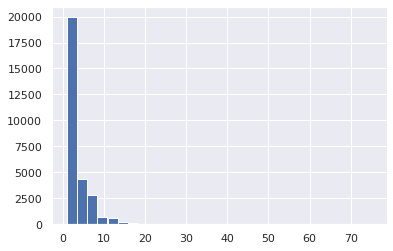

In [0]:
df_join_test.groupby('PI_IDS')['pmid'].agg('count').hist(bins=30,xscale);

In [0]:
dist_x = np.array(df_join_test.groupby('PI_IDS')['pmid'].agg('count').value_counts().index)
dist_y = np.array(df_join_test.groupby('PI_IDS')['pmid'].agg('count').value_counts())

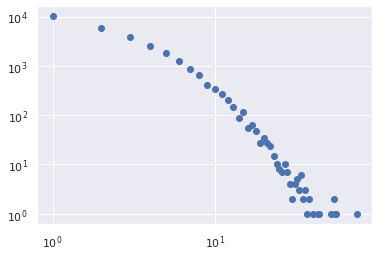

In [0]:
plt.scatter(dist_x,dist_y)
plt.xscale("log")
plt.yscale("log")

In [0]:
df_join_test.groupby('PI_IDS')['pmid'].agg('count').value_counts()

1     10177
2      5904
3      3856
4      2557
5      1786
6      1267
7       855
8       661
9       418
10      332
11      261
12      199
13      148
15      116
14       87
17       60
16       56
18       48
20       32
19       28
21       28
22       23
23       16
24       10
26        9
27        8
25        7
28        7
34        6
32        5
31        4
29        4
33        3
35        3
36        2
38        2
54        2
30        2
44        1
56        1
75        1
40        1
43        1
37        1
55        1
52        1
Name: pmid, dtype: int64